# ARIMA Time-Series Forecasting – AAPL Stock Case Study

This notebook builds and evaluates an ARIMA model to forecast Apple Inc. (AAPL) stock returns using historical weekly data. We focus on practical forecasting, model diagnostics, and backtesting for real-world applicability.


In [1]:
!pip install --user statsmodels

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%config InlineBackend.figure_format = 'retina'

df = pd.read_csv('AAPL10Y.csv')

df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)
df_week = df.resample('W').mean()
df_week = df_week[['close']]
df_week['weekly_ret'] = np.log(df_week['close']).diff()

# drop null rows
df_week.dropna(inplace=True)


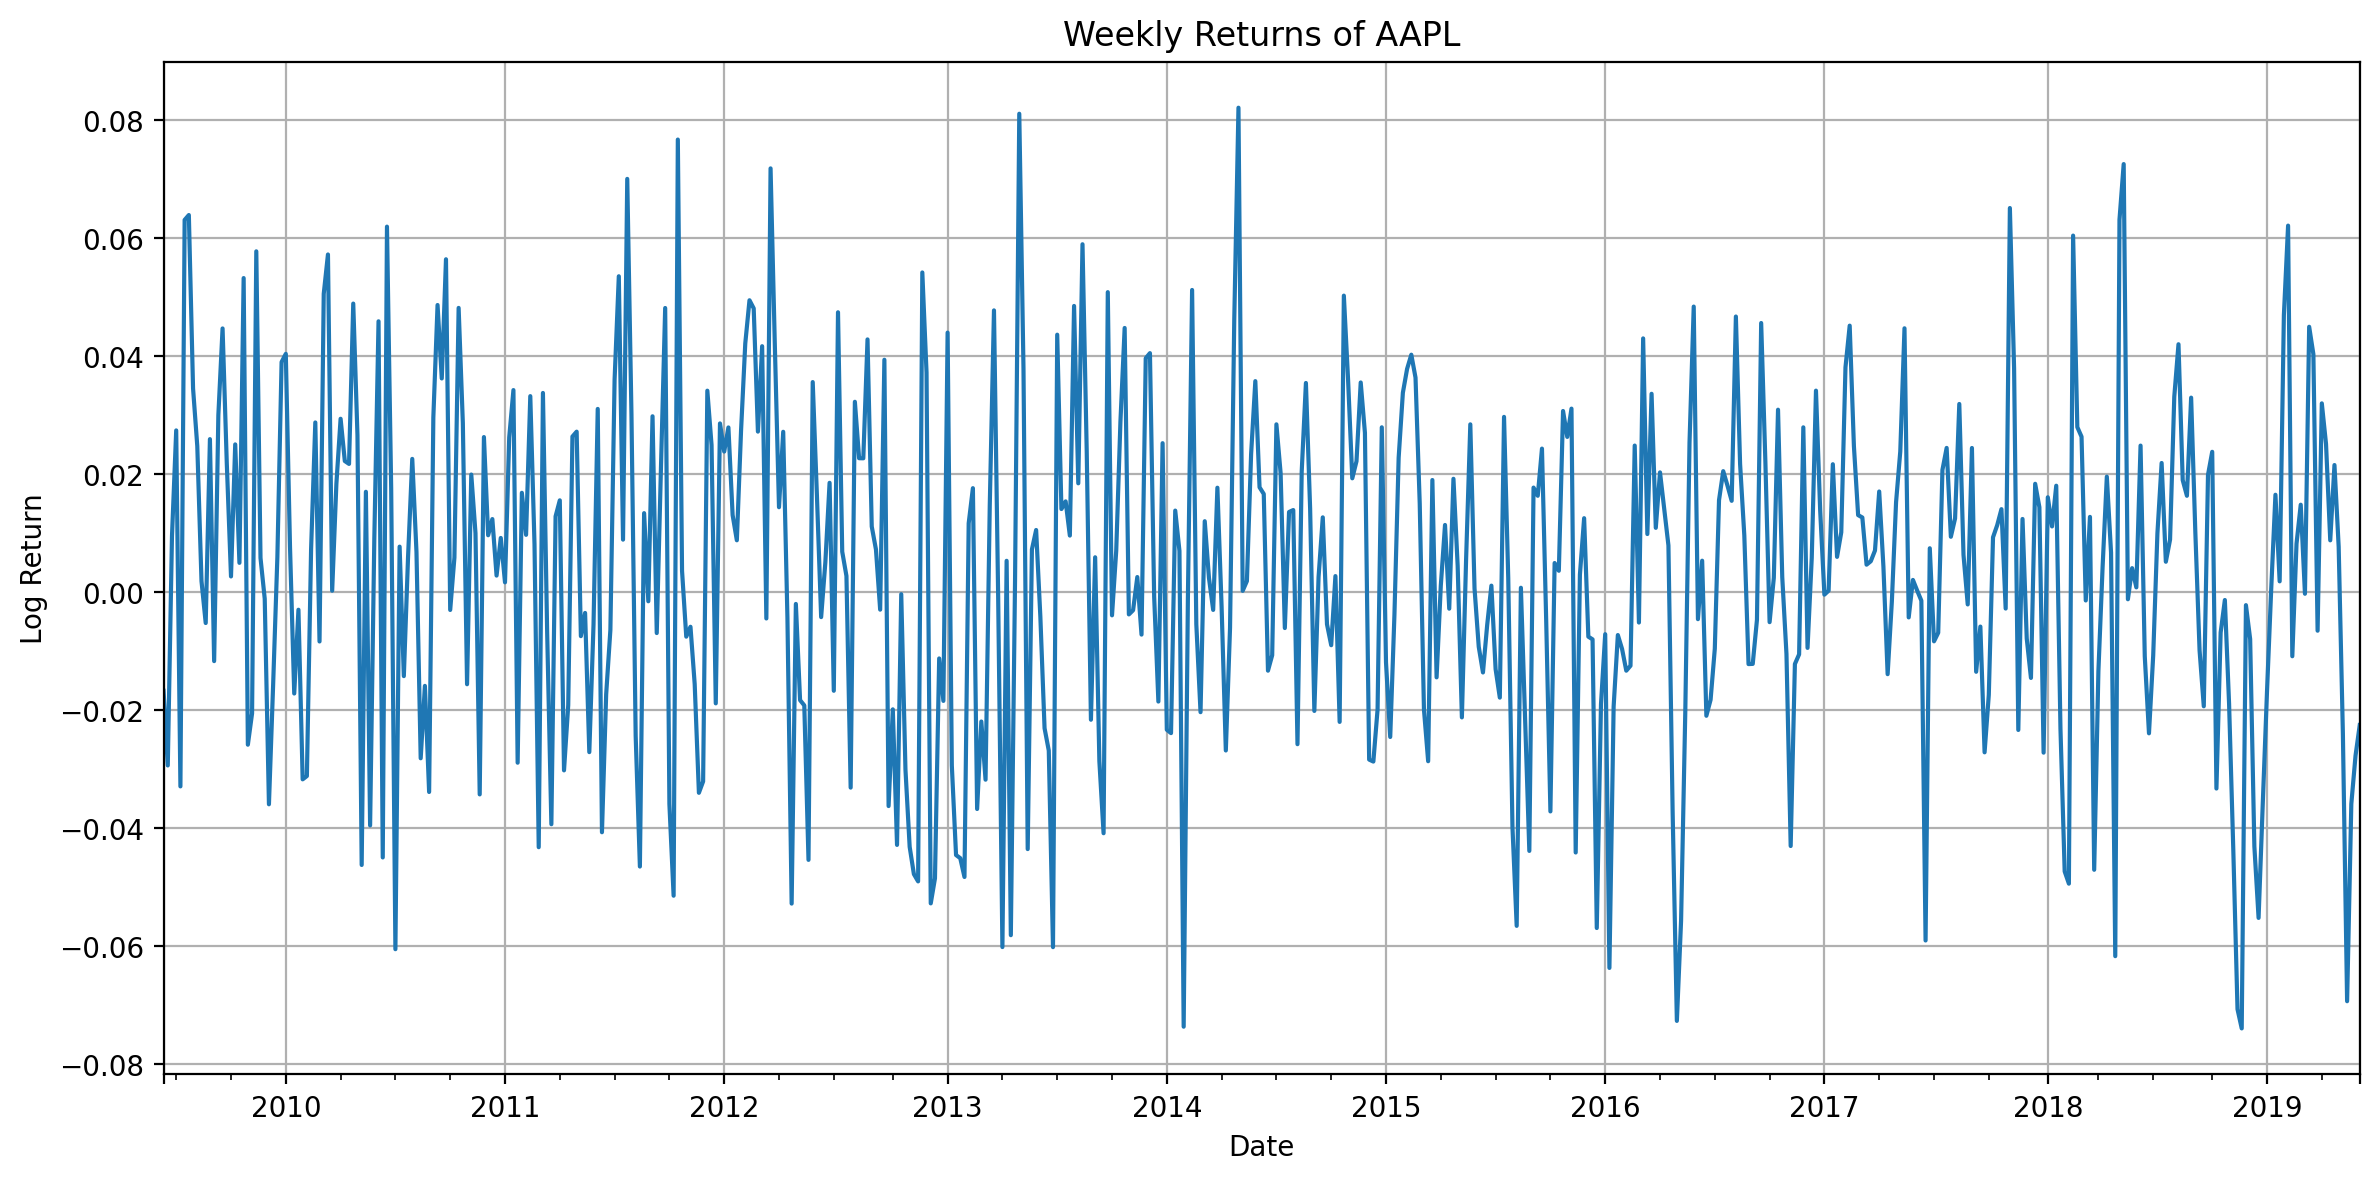

In [3]:
import matplotlib.pyplot as plt

df_week['weekly_ret'].plot(kind='line', figsize=(12, 6))
plt.title("Weekly Returns of AAPL")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.tight_layout()
plt.show()

## Test for stationarity of the udiff series

Time series are stationary if they do not contain trends or seasonal swings. The Dickey-Fuller test can be used to test for stationarity. 

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

udiff = df_week.drop(['close'], axis=1)

rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

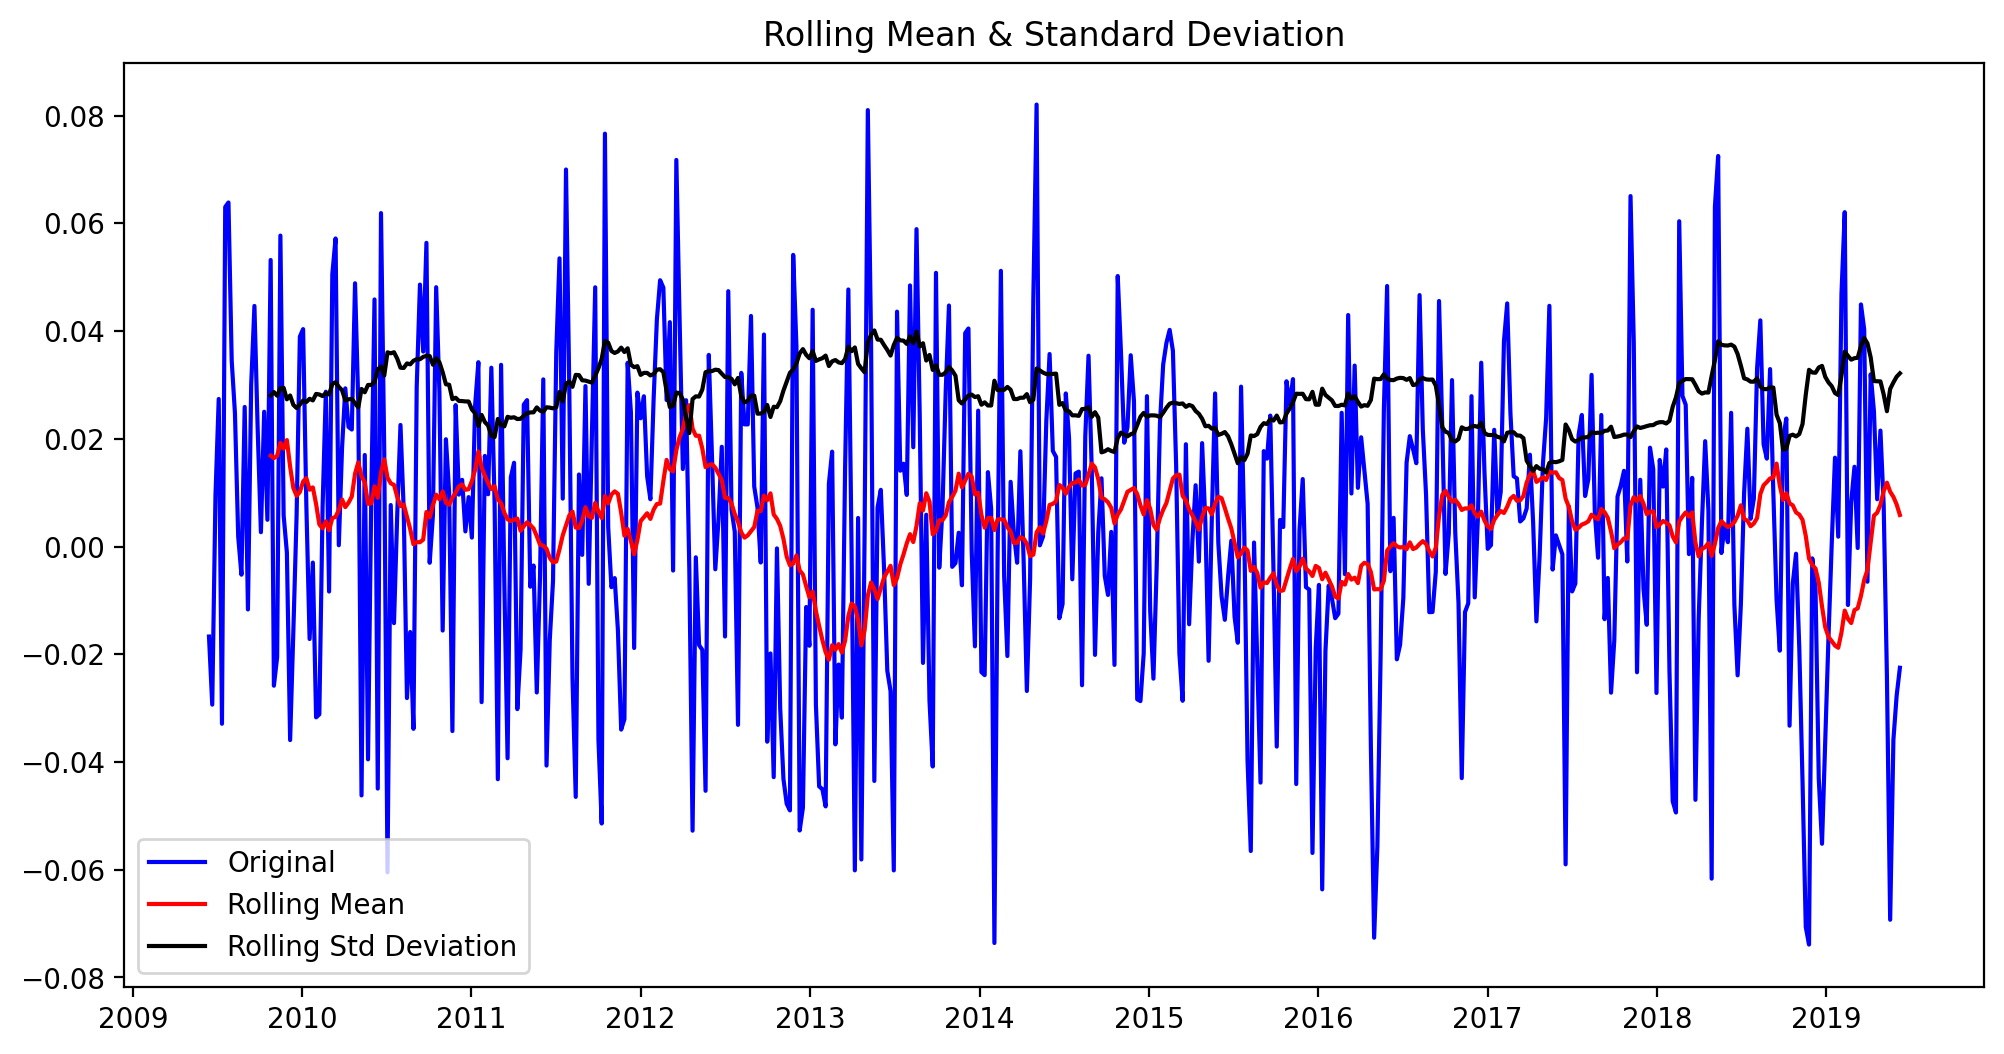

In [5]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [6]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.105002e+01
p-value                        5.107869e-20
#Lags Used                     2.000000e+00
Number of Observations Used    5.190000e+02
Critical Value (1%)           -3.443013e+00
Critical Value (5%)           -2.867125e+00
Critical Value (10%)          -2.569745e+00
dtype: float64

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them. 

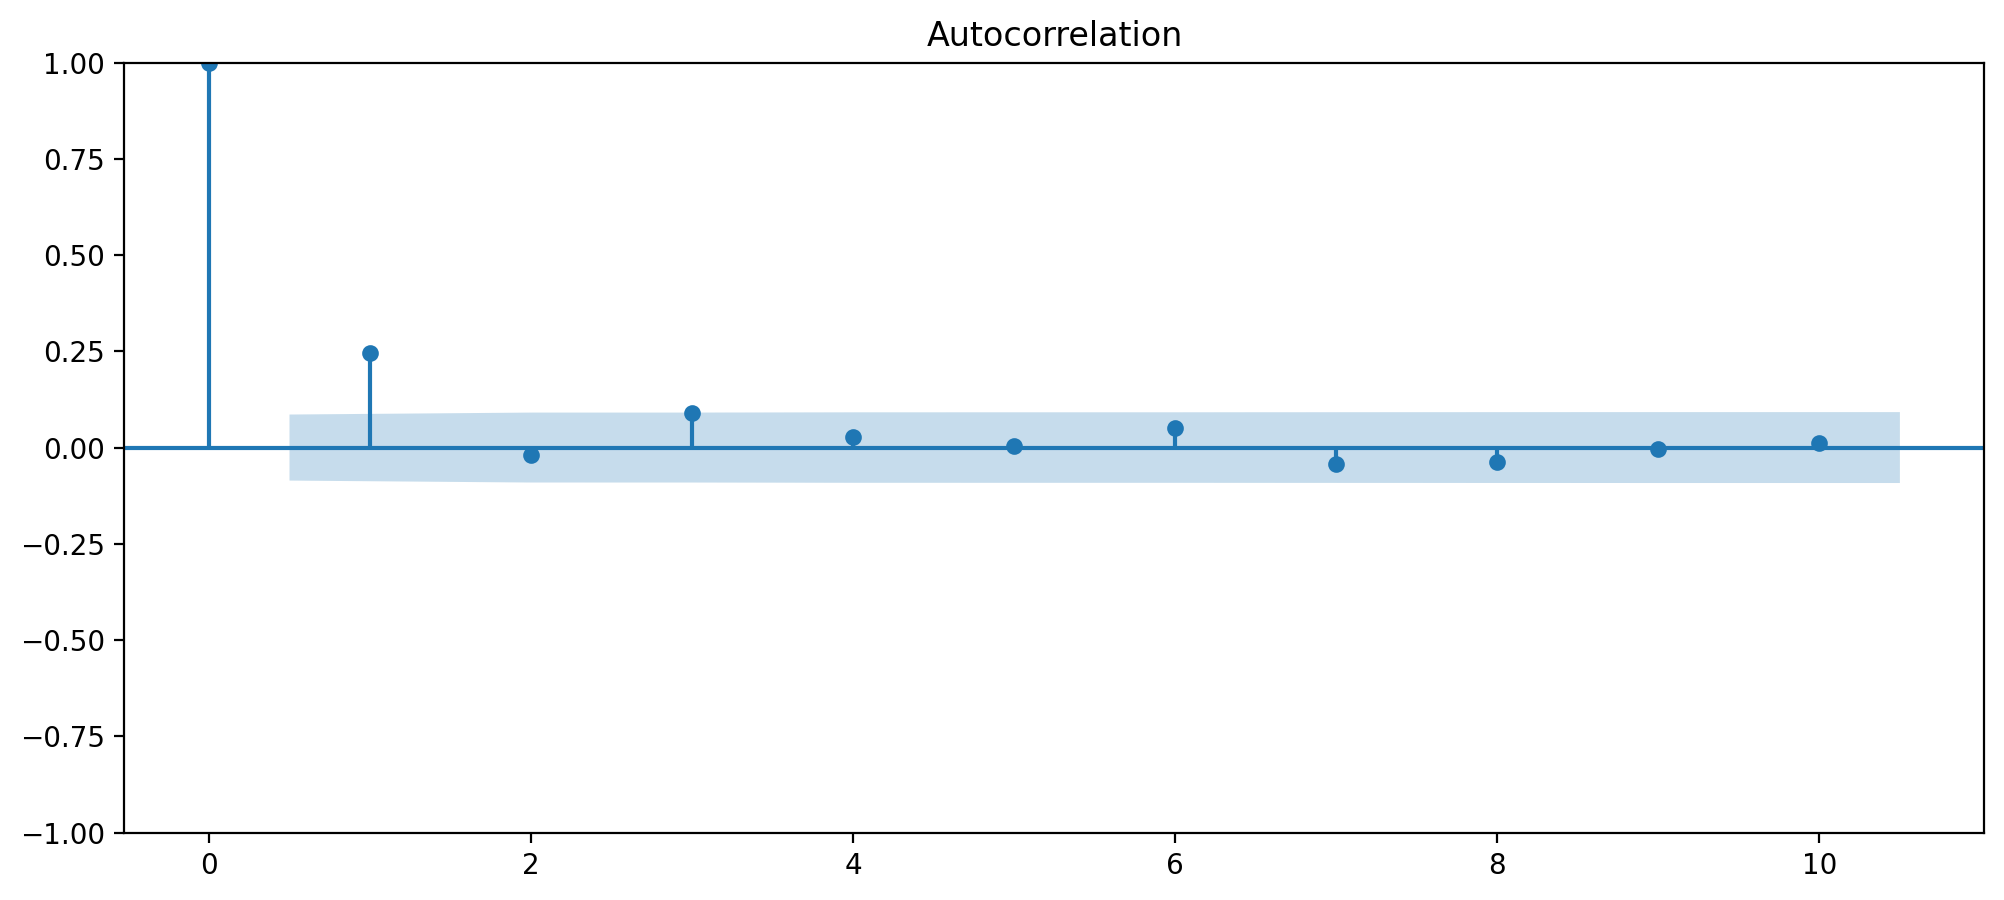

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

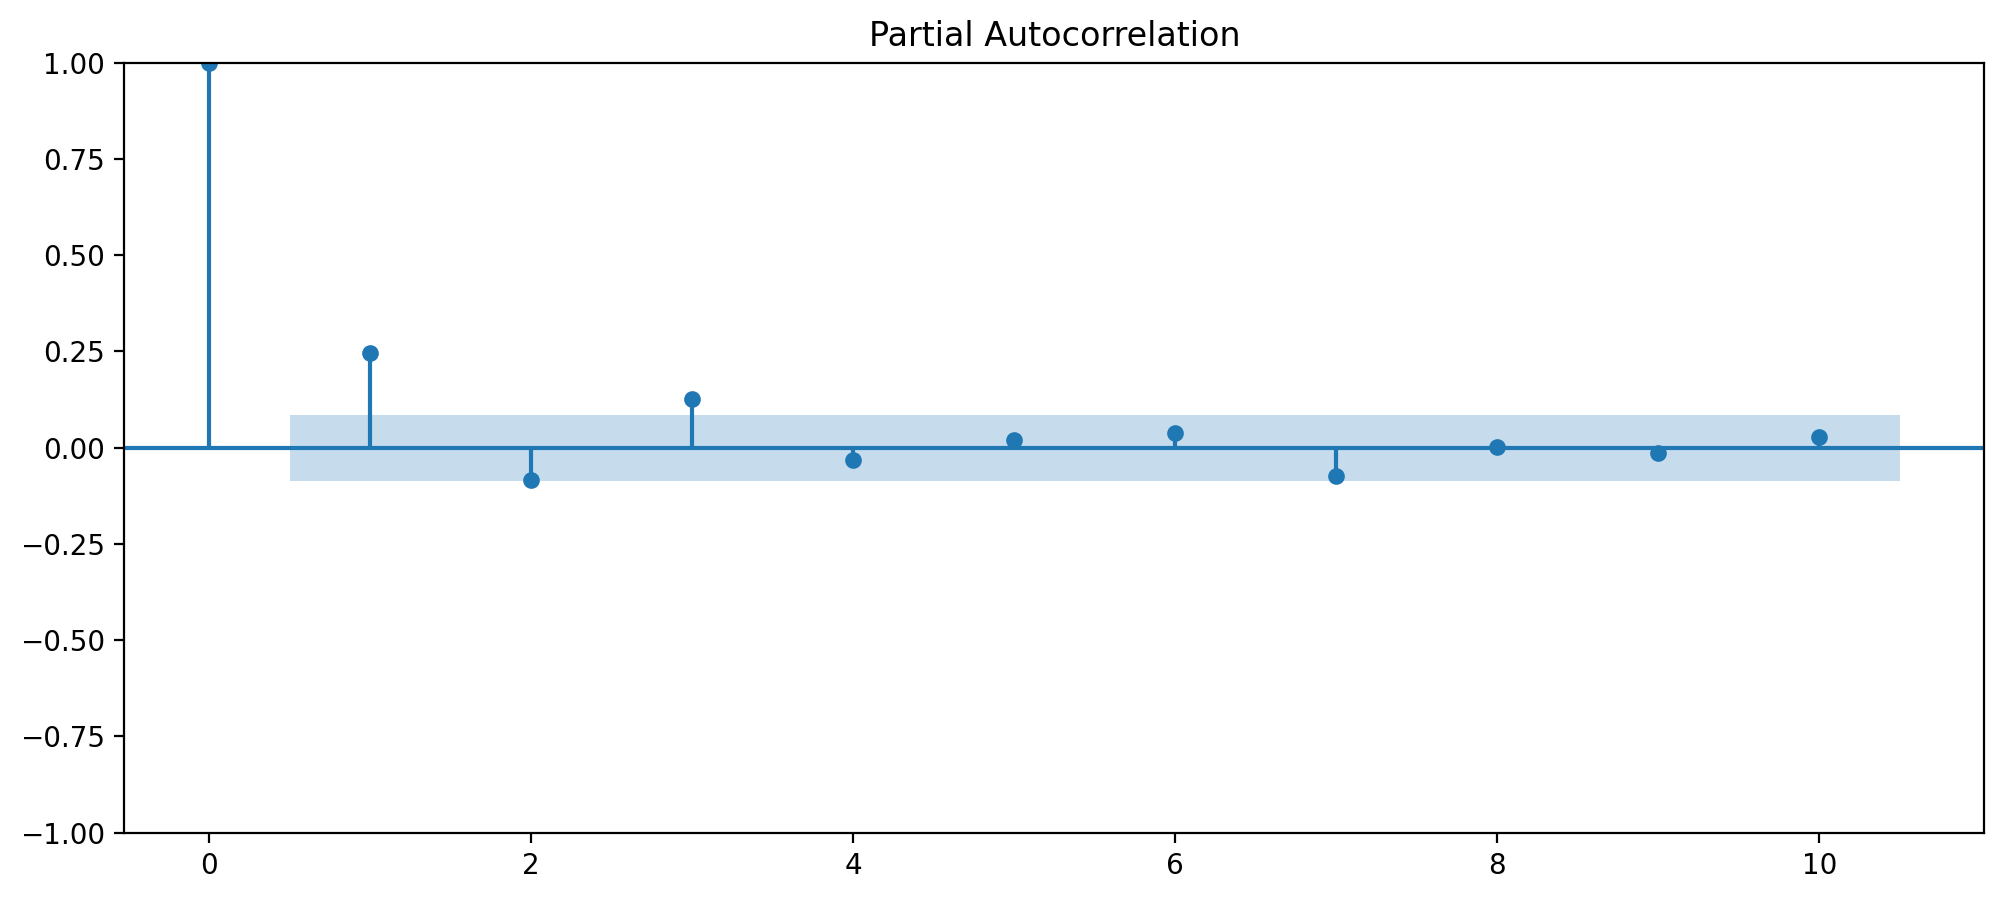

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

**Note:** Based on the ACF and PACF plots above, we can estimate ARIMA(p=3, d=0, q=1).

## Build ARIMA Model

Since we differenced the weekly closing prices, we technically only need to build an ARMA model. The data has already been integrated and is stationary. 

In [9]:
from statsmodels.tsa.arima.model import ARIMA

ar1 = ARIMA(udiff.values, order = (3, 0,1)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  522
Model:                 ARIMA(3, 0, 1)   Log Likelihood                1131.553
Date:                Wed, 23 Jul 2025   AIC                          -2251.105
Time:                        23:21:56   BIC                          -2225.559
Sample:                             0   HQIC                         -2241.100
                                - 522                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.345      0.019       0.001       0.007
ar.L1          0.1259      0.337      0.373      0.709      -0.536       0.787
ar.L2         -0.0770      0.101     -0.765      0.444      -0.274       0.120
ar.L3          0.1140      0.058      1.958      0.050      -0.000       0.228
ma.L1          0.1562      0.340      0.459      0.646      -0.510       0.822
sigma2         0.0008   4.79e-05     15.993      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.98   Prob(JB):                         1.00
Heteroskedasticity (H):               0.75   Skew:                            -0.01
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Our model doesn't do a good job predicting variance in the original data (peaks and valleys).

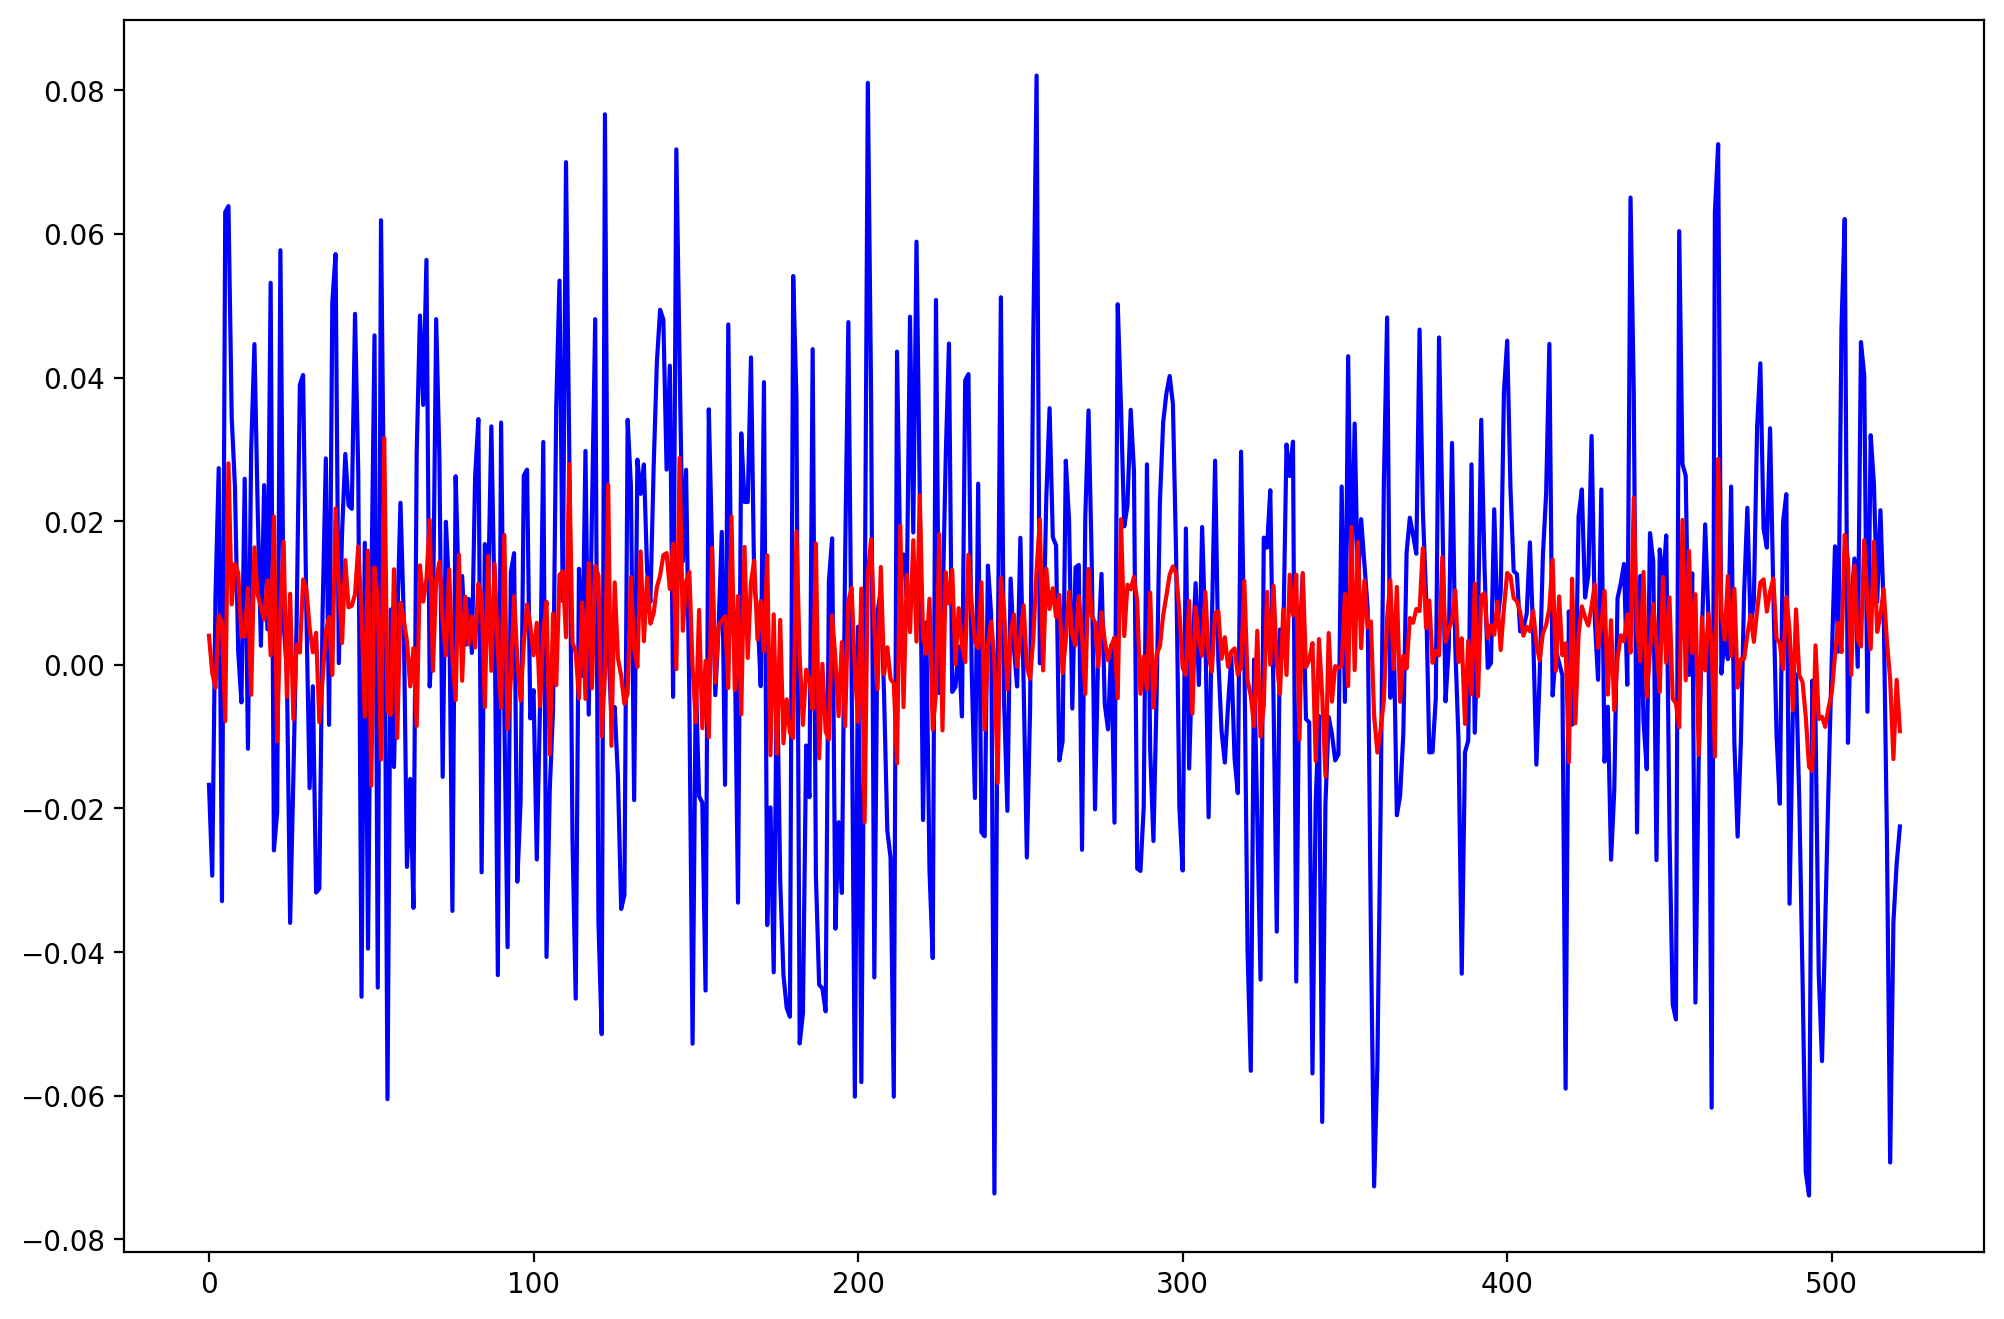

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

Let's make a forecast 2 weeks ahead:

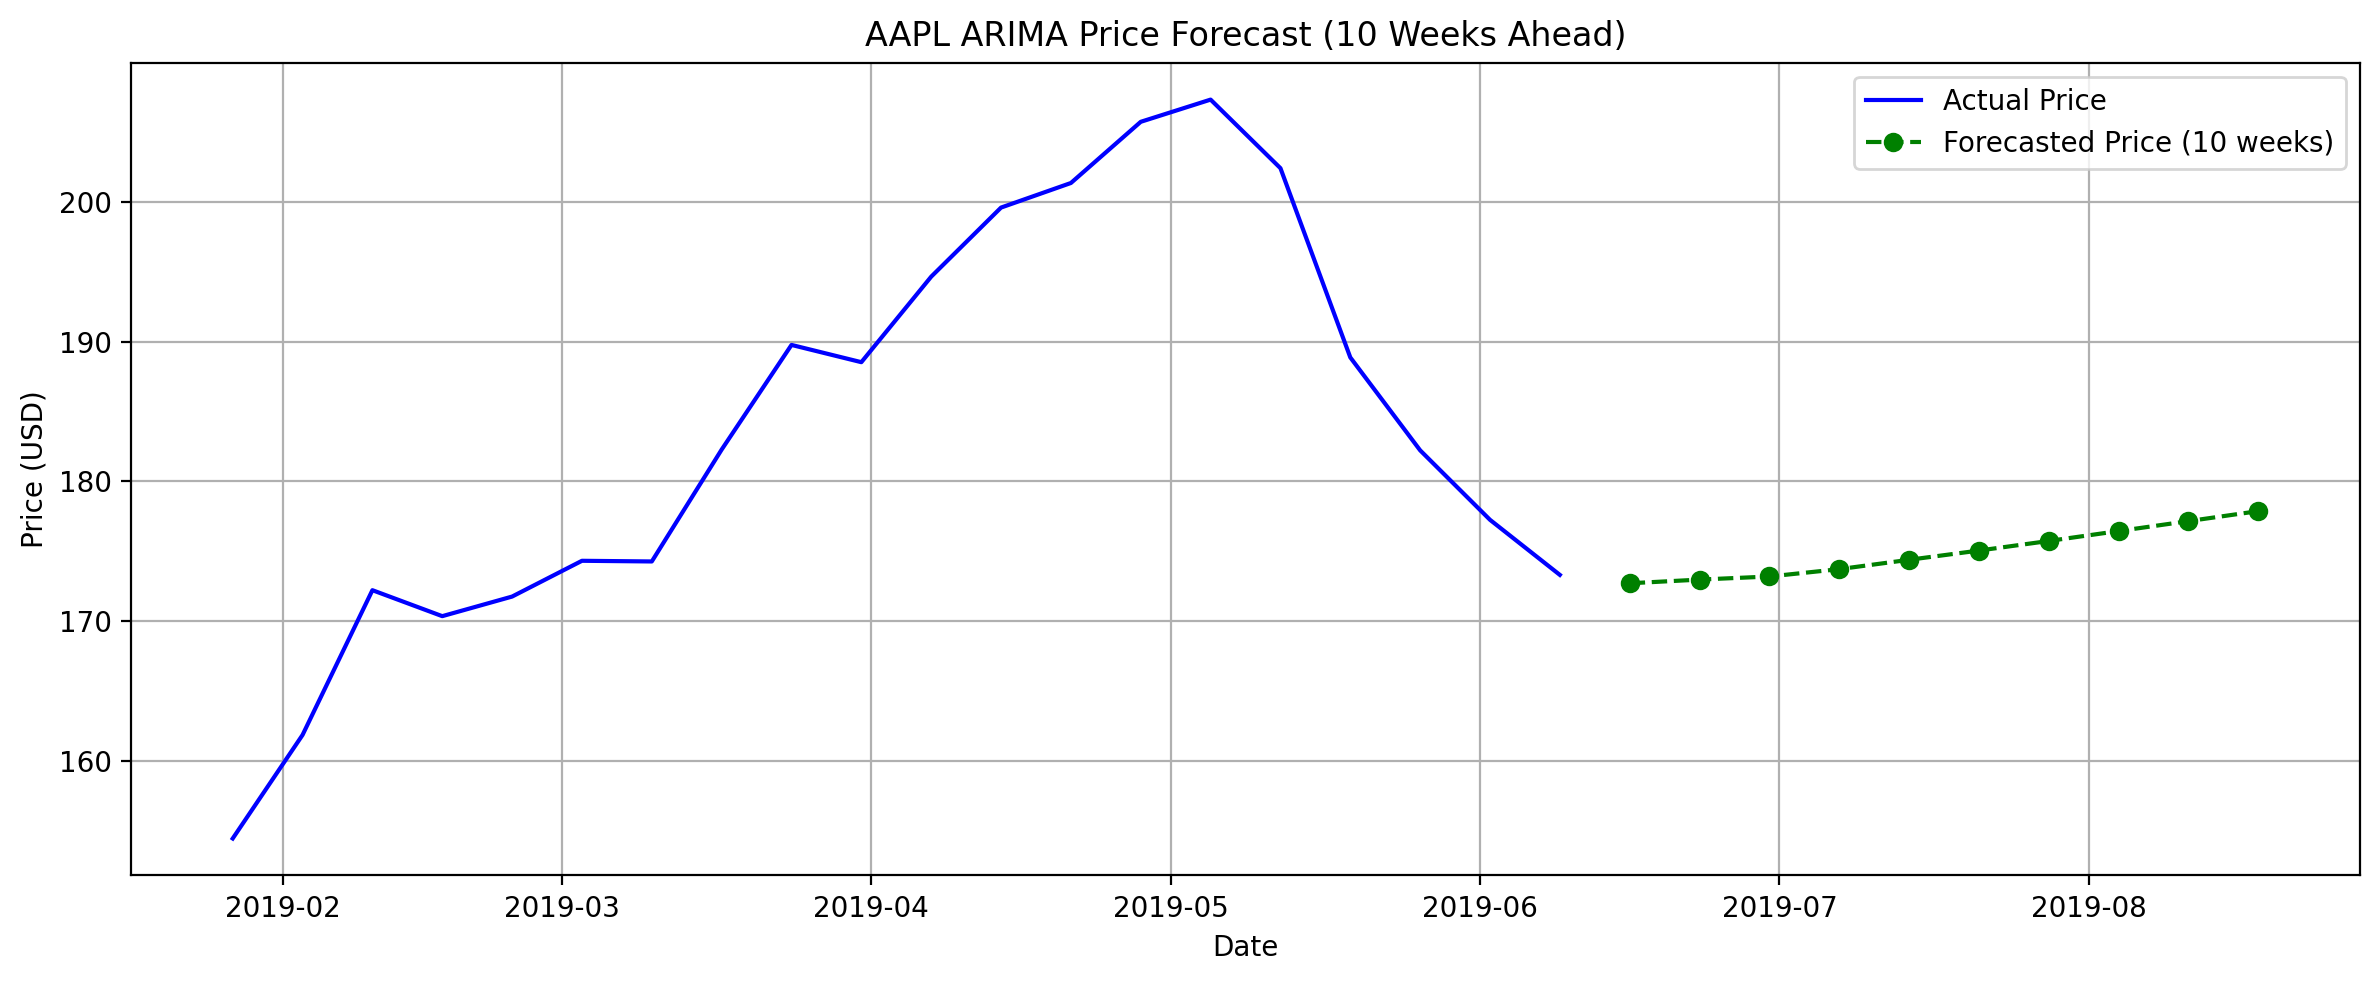

Forecasted prices for next 10 weeks: [172.69871812808938, 172.96303465685588, 173.18514002483226, 173.71189354344833, 174.38149156228886, 175.04297139509984, 175.7297771584521, 176.4392907010134, 177.15119199158377, 177.86698489546015]
Forecasted dates: DatetimeIndex(['2019-06-16', '2019-06-23', '2019-06-30', '2019-07-07',
               '2019-07-14', '2019-07-21', '2019-07-28', '2019-08-04',
               '2019-08-11', '2019-08-18'],
              dtype='datetime64[ns]', freq='W-SUN')


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


steps = 10  # Change this to any number you want for future weeks


arima_result = ARIMA(df_week['weekly_ret'], order=(3,0,1)).fit()

#  Get forecasted future log returns 
forecasted_log_returns = arima_result.forecast(steps=steps).values

# Get last actual price 
last_price = df_week['close'].iloc[-1]

# Transform log returns to price forecasts 
forecasted_prices = []
current_price = last_price
for log_ret in forecasted_log_returns:
    current_price *= np.exp(log_ret)
    forecasted_prices.append(current_price)

# Get corresponding forecast dates 
forecast_dates = pd.date_range(start=df_week.index[-1], periods=steps + 1, freq='W')[1:]

# Plot actual and forecasted prices
plt.figure(figsize=(12, 5))
plt.plot(df_week['close'][-20:], label='Actual Price', color='blue')
plt.plot(forecast_dates, forecasted_prices, label=f'Forecasted Price ({steps} weeks)', color='green', marker='o', linestyle='--')
plt.title(f"AAPL ARIMA Price Forecast ({steps} Weeks Ahead)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Forecasted prices for next", steps, "weeks:", forecasted_prices)
print("Forecasted dates:", forecast_dates)

The forecast is not great but if you tune the hyper parameters some more, you might be able to reduce the errors.

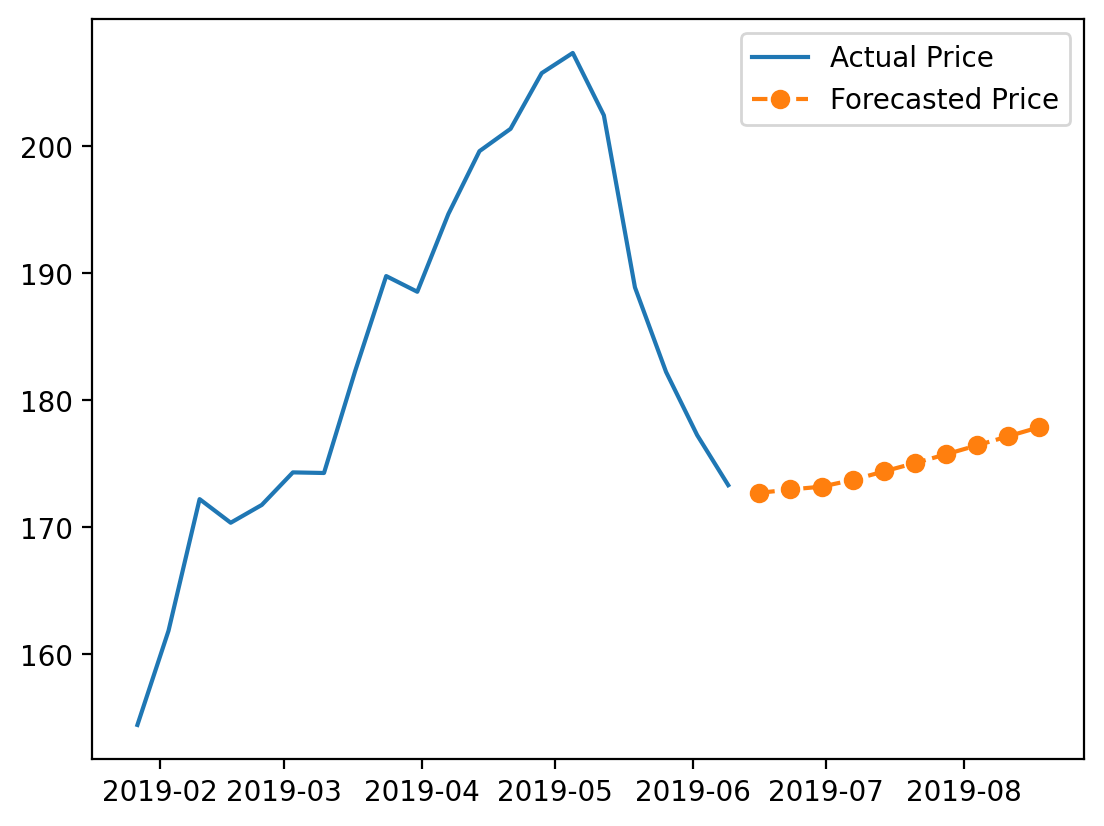

In [13]:
steps = 10
forecasted_log_returns = arima_result.forecast(steps=steps).values
last_price = df_week['close'].iloc[-1]  # last actual weekly close

# Calculate forecasted prices sequentially
forecasted_prices = []
current_price = last_price
for log_ret in forecasted_log_returns:
    current_price *= np.exp(log_ret)
    forecasted_prices.append(current_price)

# Get forecast dates
forecast_dates = pd.date_range(start=df_week.index[-1], periods=steps + 1, freq='W')[1:]

# Plot
plt.plot(df_week['close'][-20:], label='Actual Price')
plt.plot(forecast_dates, forecasted_prices, label='Forecasted Price', marker='o', linestyle='--')
plt.legend()
plt.show()

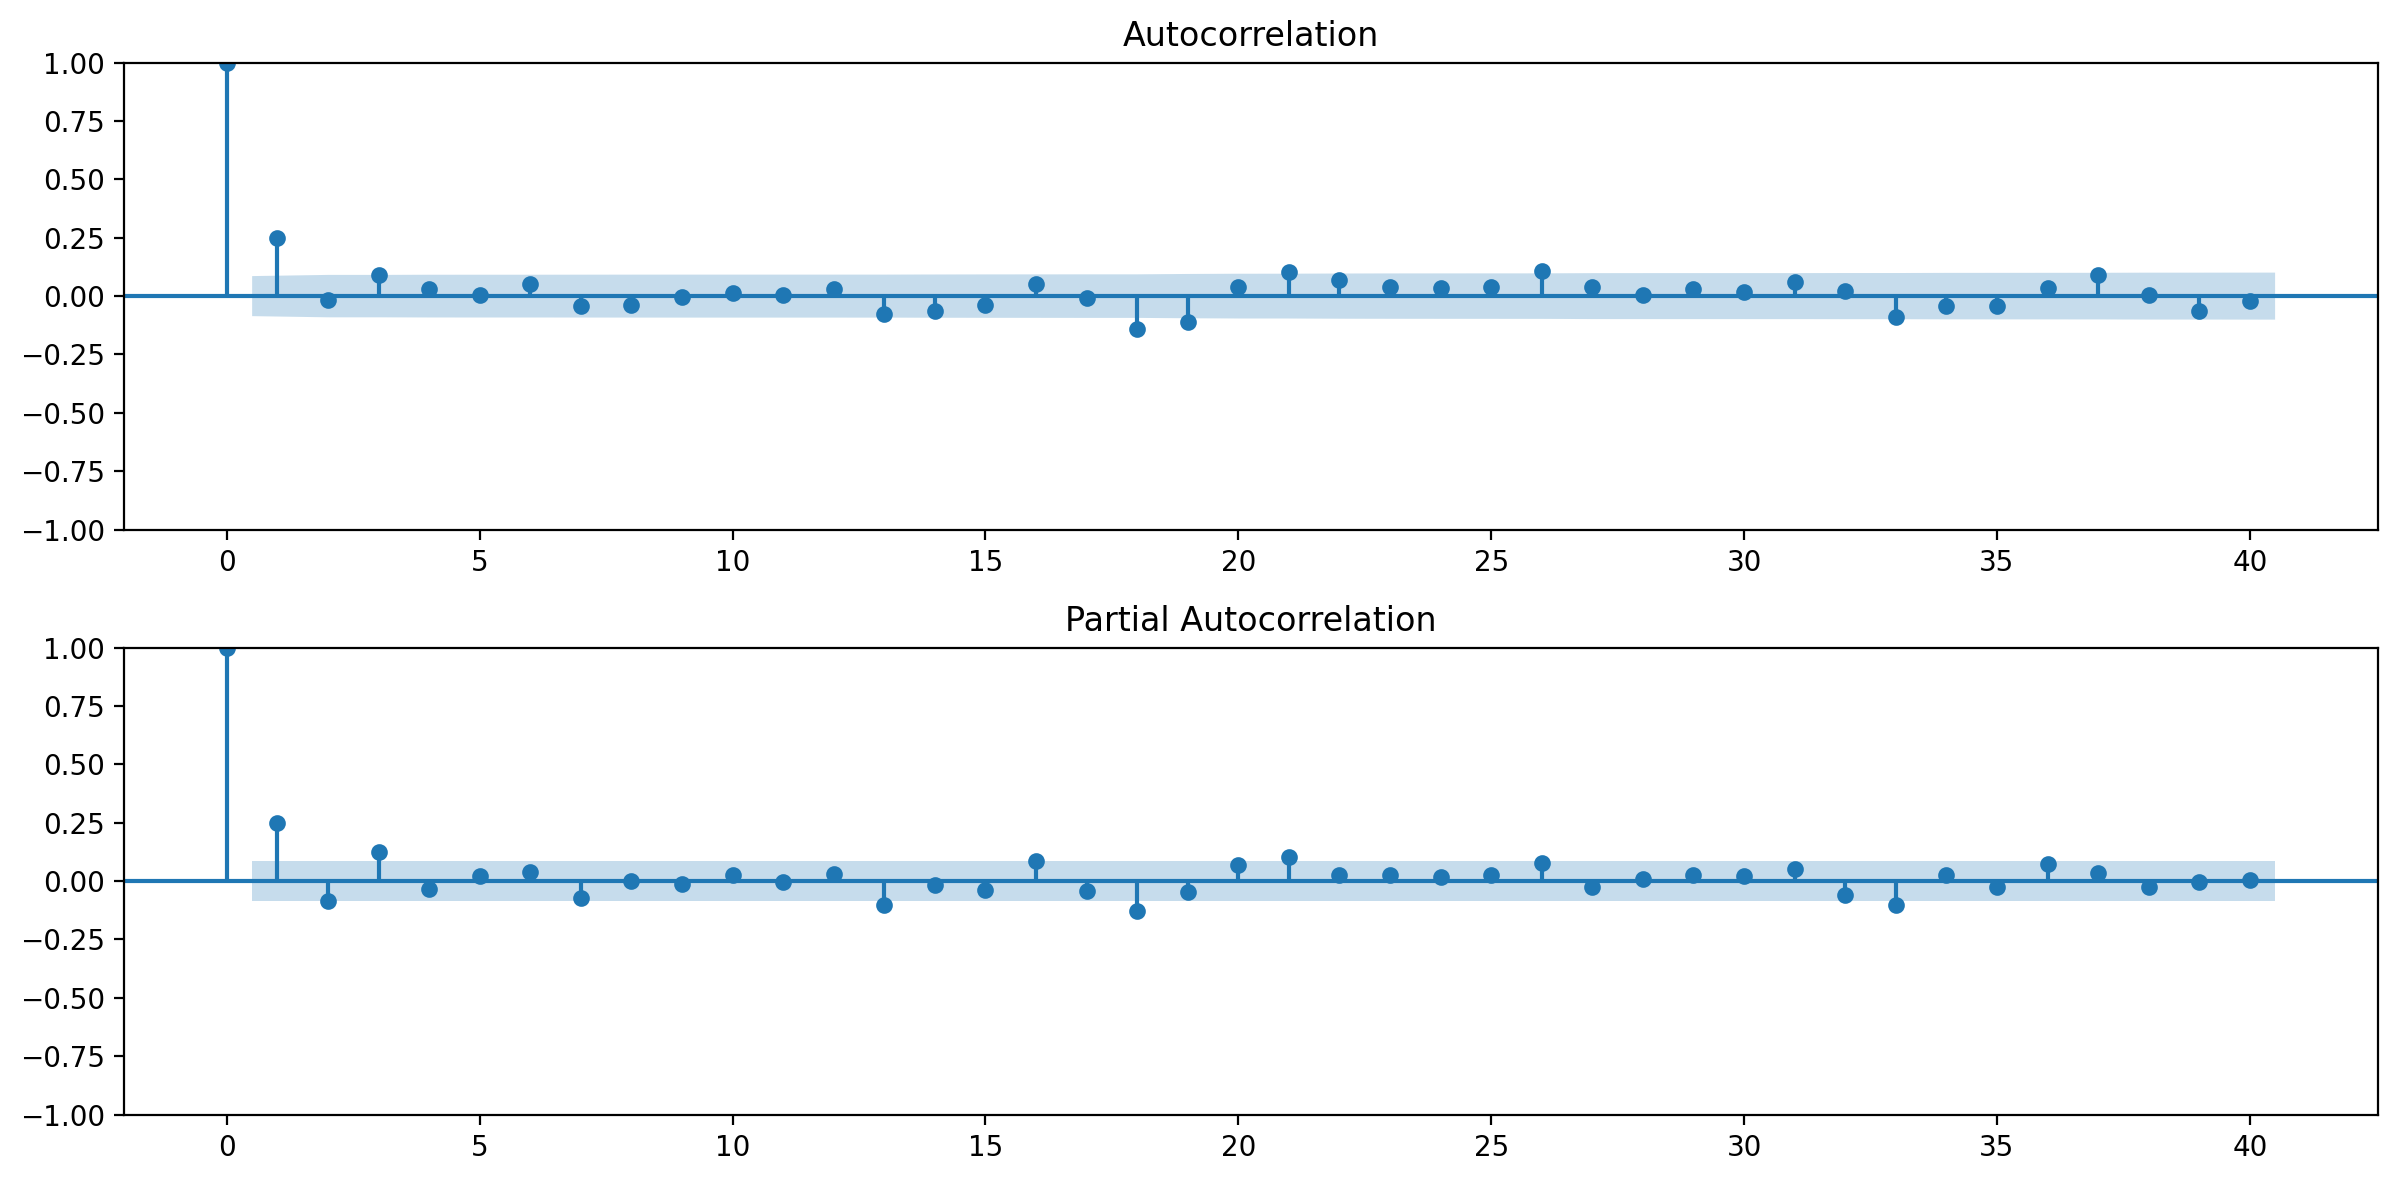

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,6))
plt.subplot(211)
plot_acf(df_week['weekly_ret'], ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(df_week['weekly_ret'], ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()

In [15]:
model = ARIMA(df_week['weekly_ret'], order=(3,0,1))
arima_result = model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:             weekly_ret   No. Observations:                  522
Model:                 ARIMA(3, 0, 1)   Log Likelihood                1131.553
Date:                Wed, 23 Jul 2025   AIC                          -2251.105
Time:                        23:33:34   BIC                          -2225.559
Sample:                    06-14-2009   HQIC                         -2241.100
                         - 06-09-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.345      0.019       0.001       0.007
ar.L1          0.1259      0.337      0.373      0.709      -0.536       0.787
ar.L2         -0.0770      0.101     -0.765      0.4

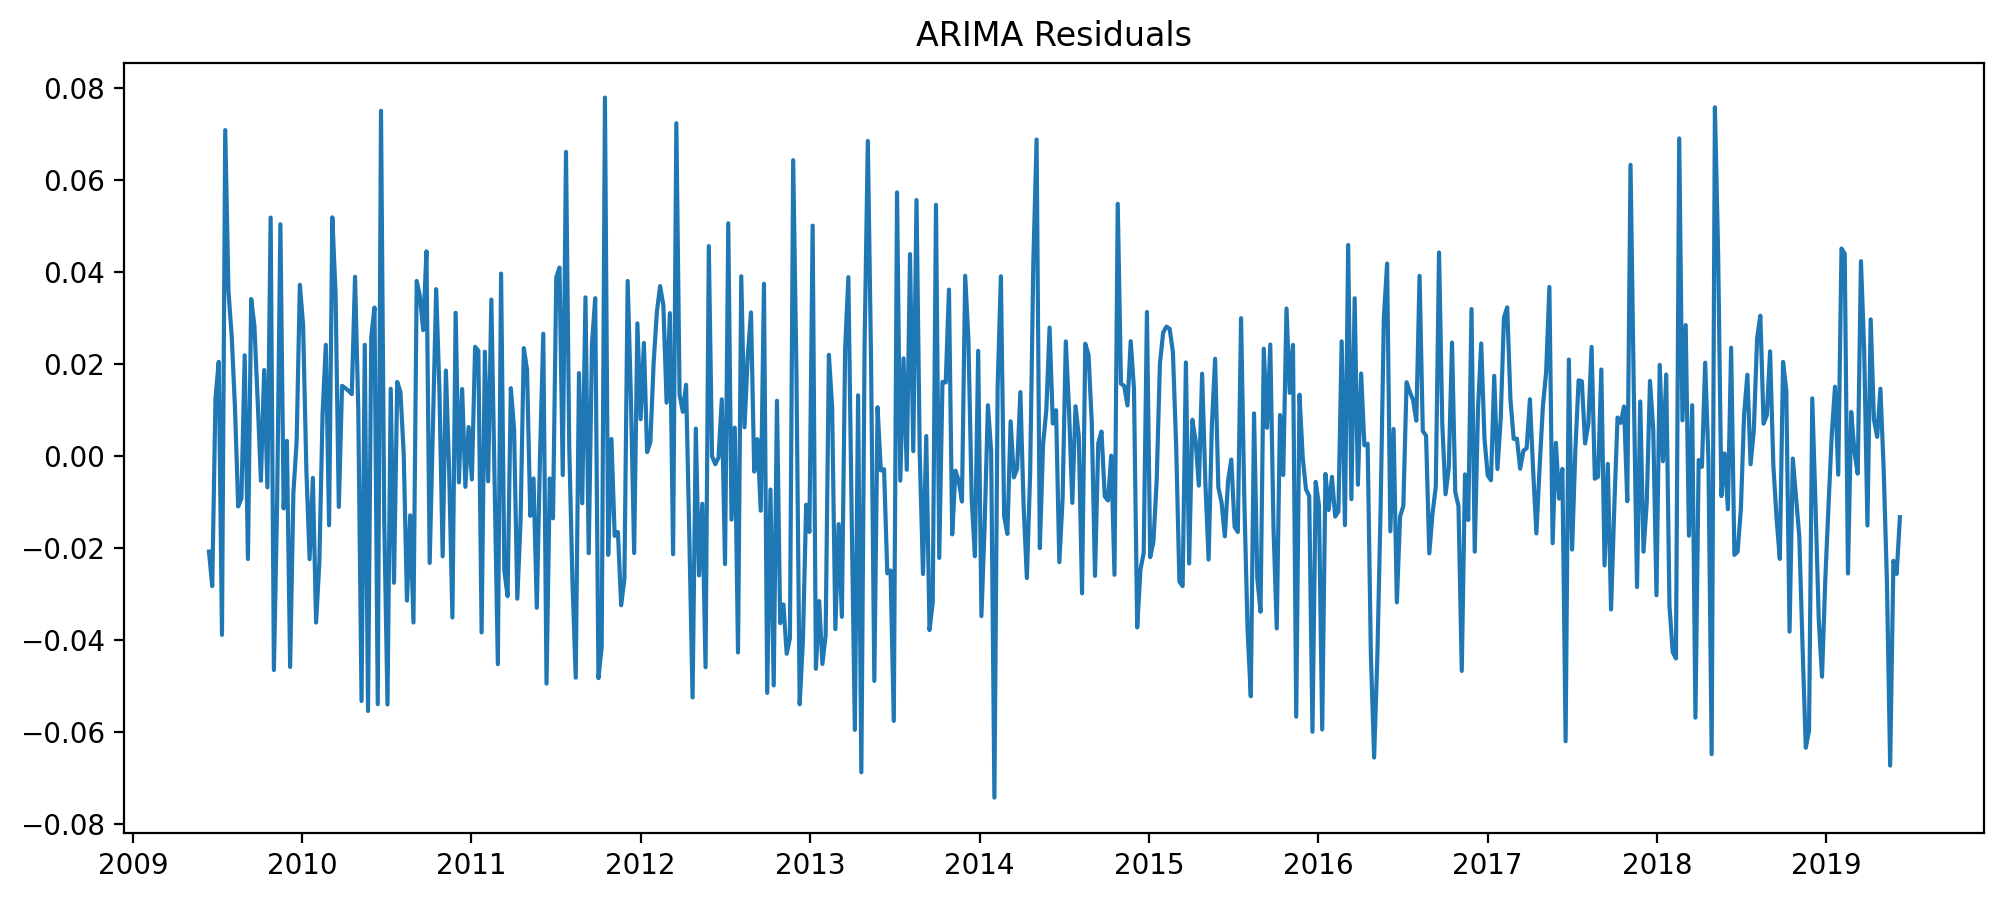

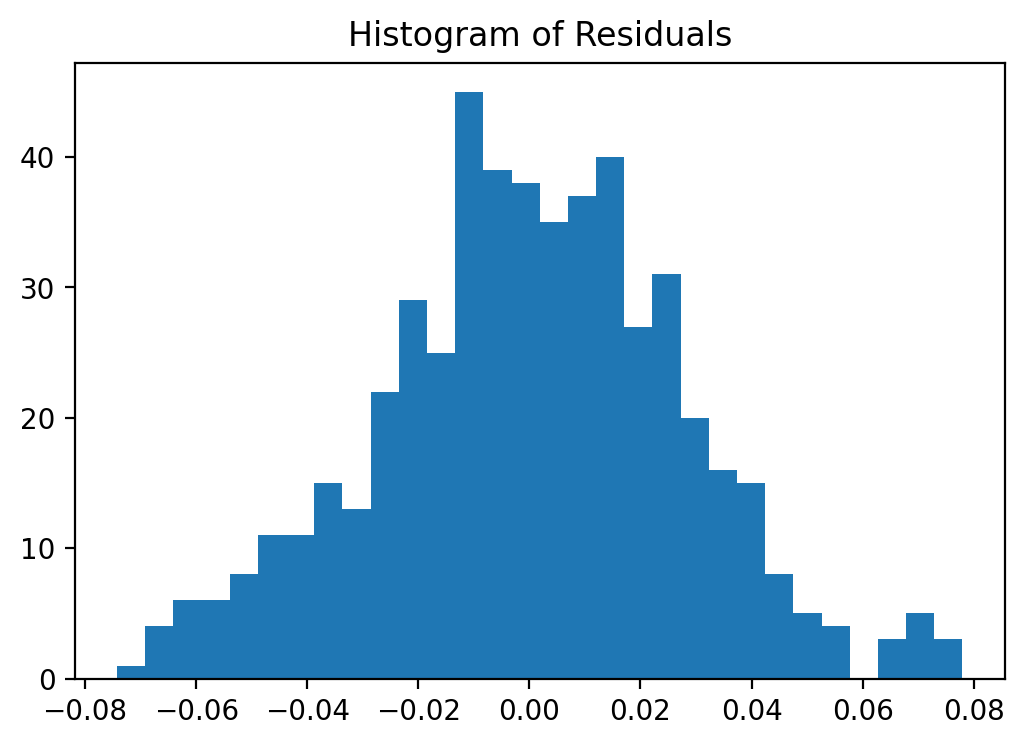

In [16]:
residuals = arima_result.resid
plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title("ARIMA Residuals")
plt.show()
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Histogram of Residuals")
plt.show()

Backtest MSE: 0.0009, MAE: 0.0227, MAPE: 1.3862


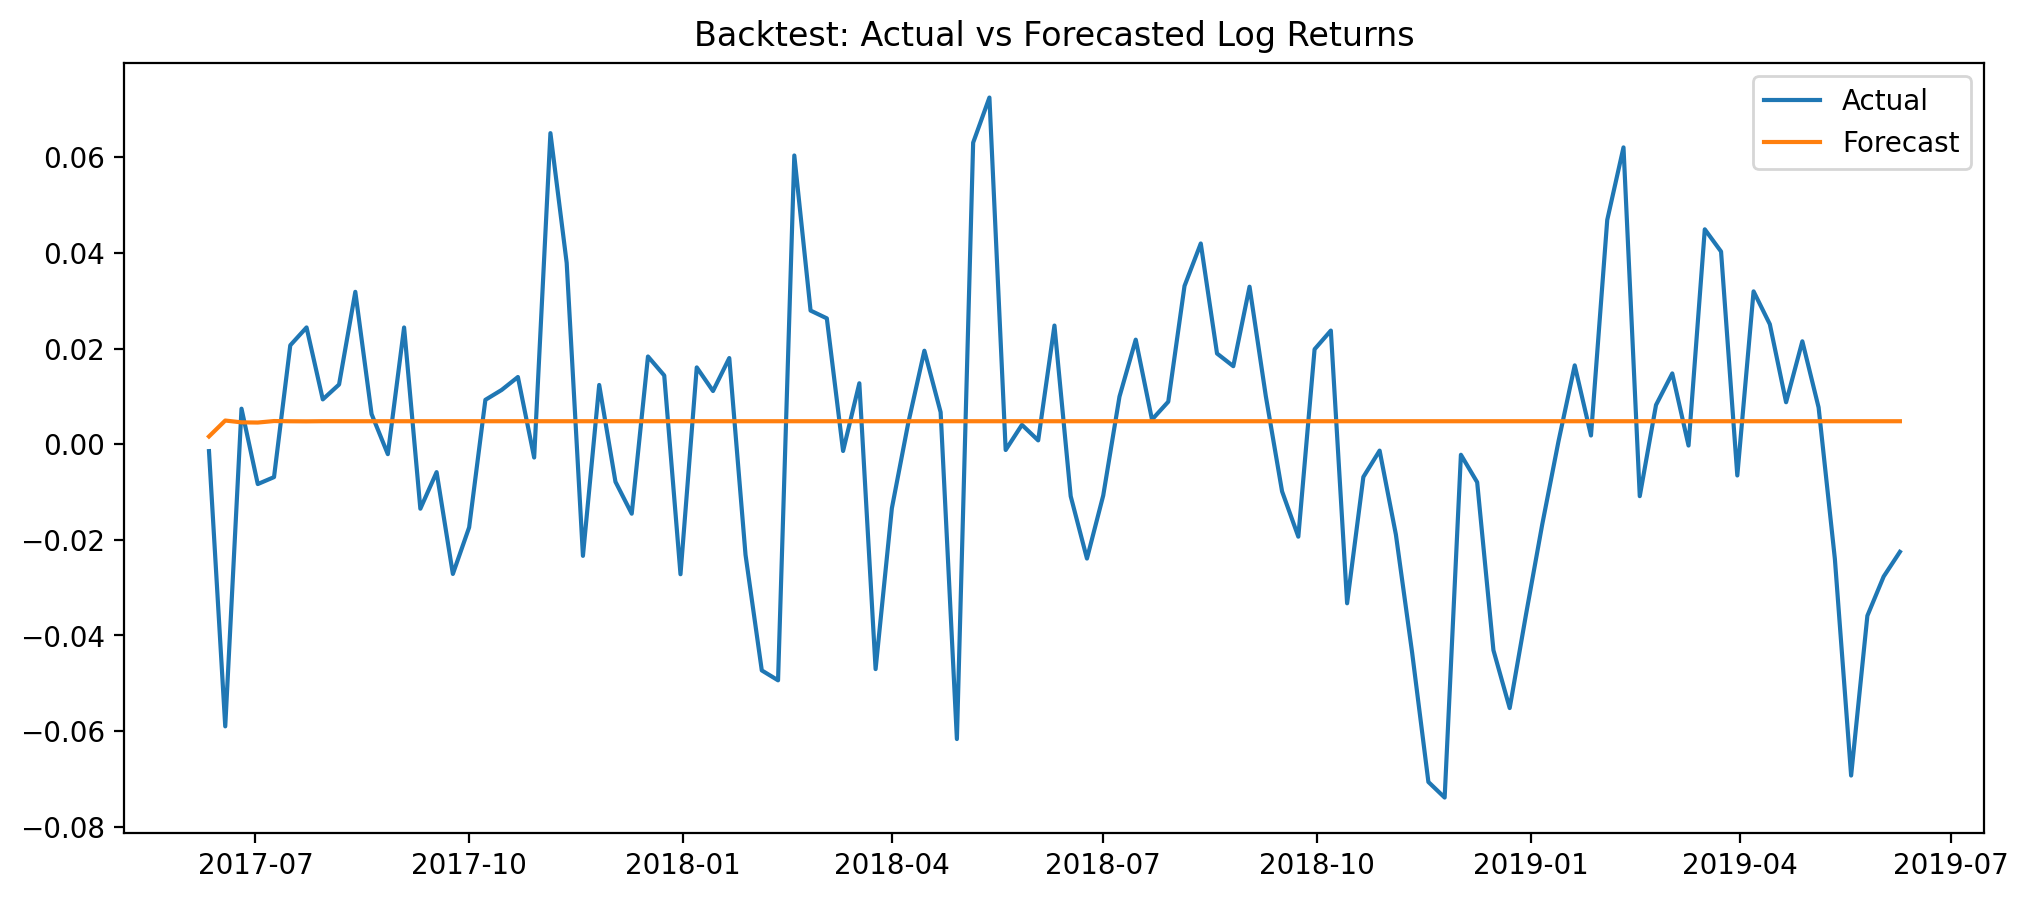

In [20]:
split = int(len(df_week)*0.8)
train = df_week['weekly_ret'][:split]
test = df_week['weekly_ret'][split:]

model_bt = ARIMA(train, order=(3,0,1))
result_bt = model_bt.fit()
forecast_bt = result_bt.forecast(steps=len(test))

# Error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
mse = mean_squared_error(test, forecast_bt)
mae = mean_absolute_error(test, forecast_bt)
mape = mean_absolute_percentage_error(test, forecast_bt)
print(f"Backtest MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

plt.figure(figsize=(12,5))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, forecast_bt, label='Forecast')
plt.legend()
plt.title("Backtest: Actual vs Forecasted Log Returns")
plt.show()

In [29]:
conf_int = arima_result.get_forecast(steps=10).conf_int()
forecasted_log_returns = arima_result.forecast(steps=10).values
last_price = df_week['close'].iloc[-1]
forecasted_prices = []
lower_prices = []
upper_prices = []
current_price = last_price
for i, log_ret in enumerate(forecasted_log_returns):
    current_price *= np.exp(log_ret)
    forecasted_prices.append(current_price)
    # Compute lower/upper bounds
    lower = np.exp(conf_int.iloc[i,0]) * last_price if i == 0 else lower_prices[-1] * np.exp(conf_int.iloc[i,0])
    upper = np.exp(conf_int.iloc[i,1]) * last_price if i == 0 else upper_prices[-1] * np.exp(conf_int.iloc[i,1])
    lower_prices.append(lower)
    upper_prices.append(upper)

plt.fill_between 

<function matplotlib.pyplot.fill_between(x: 'ArrayLike', y1: 'ArrayLike | float', y2: 'ArrayLike | float' = 0, where: 'Sequence[bool] | None' = None, interpolate: 'bool' = False, step: "Literal['pre', 'post', 'mid'] | None" = None, *, data=None, **kwargs) -> 'PolyCollection'>